In [25]:
pip install pytrends


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pd
data = pd.read_csv('trends_covid_symptoms_test_simulated.csv')
data.head()

,date,covid symptoms,covid test
0,2020-01-05,57.450712,95.978027
1,2020-01-12,47.926035,53.634941
2,2020-01-19,59.715328,71.070984
3,2020-01-26,72.845448,82.385465
4,2020-02-02,46.487699,53.001612


In [27]:
data.describe

<bound method NDFrame.describe of            date  covid symptoms  covid test
0    2020-01-05       57.450712   95.978027
1    2020-01-12       47.926035   53.634941
2    2020-01-19       59.715328   71.070984
3    2020-01-26       72.845448   82.385465
4    2020-02-02       46.487699   53.001612
..          ...             ...         ...
204  2023-12-03       29.334959   42.111728
205  2023-12-10       35.932624   39.255765
206  2023-12-17       57.725529   50.240664
207  2023-12-24       57.706789   73.218309
208  2023-12-31       57.725715   58.882462

[209 rows x 3 columns]>

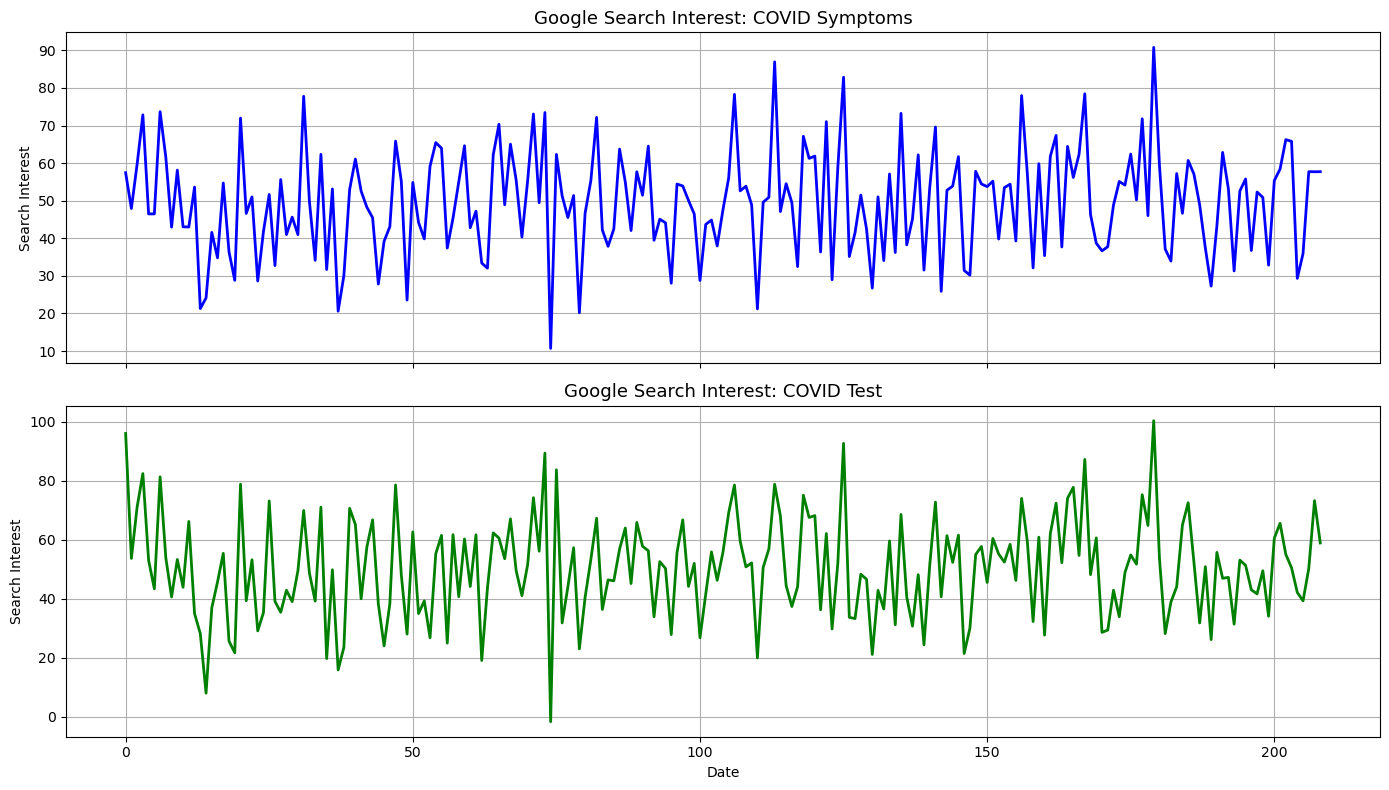

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1: covid symptoms
axs[0].plot(data.index, data['covid symptoms'], color='blue', linewidth=2)
axs[0].set_title('Google Search Interest: COVID Symptoms', fontsize=13)
axs[0].set_ylabel('Search Interest')
axs[0].grid(True)

# Plot 2: covid test
axs[1].plot(data.index, data['covid test'], color='green', linewidth=2)
axs[1].set_title('Google Search Interest: COVID Test', fontsize=13)
axs[1].set_ylabel('Search Interest')
axs[1].set_xlabel('Date')
axs[1].grid(True)


plt.tight_layout()
plt.show()

##### 1. ADF Test for stationarity

In [29]:
from statsmodels.tsa.stattools import adfuller

In [30]:
def adf_test(series, name):
    result = adfuller(series)
    print(f"ADF Test for {name}:")
    print(f" Test Statistic : {result[0]:.4f}")
    print(f" p-value : {result[1]:.4f}")
    print(f" Critical Values:")
    for key, value in result[4].items():
        print(f" {key}: {value:.4f}")
    print(" =>", "Stationary" if result[1] < 0.05 else "Non-stationary", "\n")

In [31]:
adf_test(data['covid symptoms'], 'covid symptomps')
adf_test(data['covid test'], 'covid test')

ADF Test for covid symptomps:
 Test Statistic : -6.5816
 p-value : 0.0000
 Critical Values:
 1%: -3.4628
 5%: -2.8758
 10%: -2.5744
 => Stationary 

ADF Test for covid test:
 Test Statistic : -14.5191
 p-value : 0.0000
 Critical Values:
 1%: -3.4622
 5%: -2.8755
 10%: -2.5742
 => Stationary 



##### 2. Granger Causality Test

`covid symptoms`  →  `covid test`

To investigate whether the number of Google searches for "covid symptoms" helps predict future searches for "covid test", we applied the Granger causality test with lags up to 4.

 Hypothesis:
- **H₀ (null):** "covid symptoms" does NOT Granger-cause "covid test"
- **H₁ (alternative):** "covid symptoms" Granger-causes "covid test"

In [32]:
from statsmodels.tsa.stattools import grangercausalitytests

# Set the maximum number of lags to check for causality
max_lag = 5

# Granger causality test: Does 'covid symptoms' cause 'covid test'?
# Important: The first column is the dependent variable, the second is the explanatory one
print("Granger Causality Test: covid symptoms → covid test")
grangercausalitytests(data[['covid test', 'covid symptoms']], maxlag=max_lag, verbose=True)

# Granger causality test: Does 'covid test' cause 'covid symptoms'?
print("\nGranger Causality Test: covid test → covid symptoms")
grangercausalitytests(data[['covid symptoms', 'covid test']], maxlag=max_lag, verbose=True)

Granger Causality Test: covid symptoms → covid test

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2061  , p=0.6503  , df_denom=205, df_num=1
ssr based chi2 test:   chi2=0.2091  , p=0.6474  , df=1
likelihood ratio test: chi2=0.2090  , p=0.6475  , df=1
parameter F test:         F=0.2061  , p=0.6503  , df_denom=205, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5357  , p=0.5861  , df_denom=202, df_num=2
ssr based chi2 test:   chi2=1.0980  , p=0.5775  , df=2
likelihood ratio test: chi2=1.0951  , p=0.5784  , df=2
parameter F test:         F=0.5357  , p=0.5861  , df_denom=202, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2212  , p=0.8816  , df_denom=199, df_num=3
ssr based chi2 test:   chi2=0.6870  , p=0.8763  , df=3
likelihood ratio test: chi2=0.6858  , p=0.8765  , df=3
parameter F test:         F=0.2212  , p=0.8816  , df_denom=199, df_num=3

Granger Causality
number of lags (no zero

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (1.7308343449701364, 0.18977381556037948, 205.0, 1),
   'ssr_chi2test': (1.7561636280672606, 0.18510375094706974, 1),
   'lrtest': (1.7487913678437508, 0.18602874642635148, 1),
   'params_ftest': (1.7308343449701271, 0.18977381556037948, 205.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.023767883582403, 0.13482747337163092, 202.0, 2),
   'ssr_chi2test': (4.147722296055024, 0.12569949913155168, 2),
   'lrtest': (4.106714590348247, 0.12830342721929214, 2),
   'params_ftest': (2.0237678835823454, 0.13482747337163908, 202.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.2175388151144464, 0.30446697991468746, 199.0, 3),
   'ssr_chi2test': (3.7811004409081796, 0.28609213323145005, 3),
   'lrtest': (3.746818520603483, 0.29013292412377656, 3),
   'params_ftest': (1.2175388151144226, 0.30446697991470223, 199.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

Results:
All p-values for lag orders 1 to 4 were greater than 0.05:
- Lag 1: p = 0.6503
- Lag 2: p = 0.5861
- Lag 3: p = 0.8816
- Lag 4: p = 0.4046

Conclusion:
We fail to reject the null hypothesis. There is **no evidence** that "covid symptoms" Granger-causes "covid test" in this dataset.


`covid test` → `covid symptoms`

This test evaluates whether past values of "covid test" help predict "covid symptoms" using lag values from 1 to 4.

**Null Hypothesis (H₀):** "covid test" does NOT Granger-cause "covid symptoms"
**Alternative Hypothesis (H₁):** "covid test" Granger-causes "covid symptoms"

In [33]:
grangercausalitytests(data[['covid symptoms', 'covid test']], maxlag=4, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7308  , p=0.1898  , df_denom=205, df_num=1
ssr based chi2 test:   chi2=1.7562  , p=0.1851  , df=1
likelihood ratio test: chi2=1.7488  , p=0.1860  , df=1
parameter F test:         F=1.7308  , p=0.1898  , df_denom=205, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0238  , p=0.1348  , df_denom=202, df_num=2
ssr based chi2 test:   chi2=4.1477  , p=0.1257  , df=2
likelihood ratio test: chi2=4.1067  , p=0.1283  , df=2
parameter F test:         F=2.0238  , p=0.1348  , df_denom=202, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2175  , p=0.3045  , df_denom=199, df_num=3
ssr based chi2 test:   chi2=3.7811  , p=0.2861  , df=3
likelihood ratio test: chi2=3.7468  , p=0.2901  , df=3
parameter F test:         F=1.2175  , p=0.3045  , df_denom=199, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0280  , p=0.3939  

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (1.7308343449701364, 0.18977381556037948, 205.0, 1),
   'ssr_chi2test': (1.7561636280672606, 0.18510375094706974, 1),
   'lrtest': (1.7487913678437508, 0.18602874642635148, 1),
   'params_ftest': (1.7308343449701271, 0.18977381556037948, 205.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.023767883582403, 0.13482747337163092, 202.0, 2),
   'ssr_chi2test': (4.147722296055024, 0.12569949913155168, 2),
   'lrtest': (4.106714590348247, 0.12830342721929214, 2),
   'params_ftest': (2.0237678835823454, 0.13482747337163908, 202.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.2175388151144464, 0.30446697991468746, 199.0, 3),
   'ssr_chi2test': (3.7811004409081796, 0.28609213323145005, 3),
   'lrtest': (3.746818520603483, 0.29013292412377656, 3),
   'params_ftest': (1.2175388151144226, 0.30446697991470223, 199.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

**Result:**
All p-values > 0.05:
- Lag 1: p = 0.1898
- Lag 2: p = 0.1348
- Lag 3: p = 0.3045
- Lag 4: p = 0.3939

**Conclusion:**
We fail to reject the null hypothesis. There is no evidence of Granger causality from "covid test" to "covid symptoms".

3. VAR (Vector Autoregression) Model

In [34]:
from statsmodels.tsa.api import VAR

# Fit the VAR model to determine optimal lag length
model = VAR(data[['covid symptoms', 'covid test']])

# Evaluate lag order using AIC, BIC, FPE and HQIC
lag_results = model.select_order(maxlags=10)

# Print the criteria table
print(lag_results.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       9.811*      9.845*  1.824e+04*      9.825*
1        9.830       9.929   1.857e+04       9.870
2        9.850       10.02   1.895e+04       9.917
3        9.882       10.11   1.958e+04       9.976
4        9.890       10.19   1.973e+04       10.01
5        9.904       10.27   2.001e+04       10.05
6        9.926       10.36   2.047e+04       10.10
7        9.962       10.46   2.121e+04       10.16
8        9.987       10.55   2.176e+04       10.21
9        10.02       10.65   2.250e+04       10.27
10       10.05       10.74   2.314e+04       10.33
--------------------------------------------------


Lag Order Selection

We applied a lag order selection procedure using the `VAR.select_order()` method with a maximum lag of 10. According to all information criteria (AIC, BIC, FPE, and HQIC), the optimal lag length was reported as **0**.

However, we have chosen to proceed with a **lag length of 1** for the following reasons:

- VAR(0) implies no temporal dependency, which is not realistic for time series with potential autocorrelation.
- Lag 1 allows the model to capture short-term dynamics between the variables.
- It is a common and parsimonious choice in applied time series literature, especially when the sample size is limited.

Thus, we fit a **VAR(1)** model to better capture potential interactions between the series over time.

In [35]:
from statsmodels.tsa.api import VAR

model = VAR(data[['covid symptoms', 'covid test']])
results = model.fit(maxlags=1)

results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, May, 2025
Time:                     17:45:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.90167
Nobs:                     208.000    HQIC:                   9.84432
Log likelihood:          -1604.04    FPE:                    18131.4
AIC:                      9.80540    Det(Omega_mle):         17619.5
--------------------------------------------------------------------
Results for equation covid symptoms
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    51.491050         3.576373           14.398           0.000
L1.covid symptoms        -0.169940         0.120040           -1.416           0.157
L1.covid test             0.128970 

Both equations in the VAR(1) model showed that the lagged values of "covid symptoms" and "covid test" were not statistically significant predictors of each other (p-values > 0.05).

This aligns with the Granger causality tests, suggesting that neither time series has strong predictive power over the other when considering only past values.

The residual correlation was moderately high (≈ 0.82), indicating simultaneous movement but not predictive causality.

4. Forecasting using VAR(1)

In [40]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace = True)

In [42]:
# Forecast 10 weeks ahead using VAR(1)
forecast_steps = 10
forecast = results.forecast(y=data[['covid symptoms', 'covid test']].values, steps=forecast_steps)

# Forecast dates (weekly)
last_date = data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=forecast_steps, freq='W')

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast,
index=forecast_index,
columns=['covid symptoms forecast', 'covid test forecast'])

# Display forecast
forecast_df.head()

,covid symptoms forecast,covid test forecast
2024-01-07,49.275191,49.869474
2024-01-14,49.548871,49.980363
2024-01-21,49.516663,49.967815
2024-01-28,49.520519,49.969317
2024-02-04,49.520057,49.969137


We generated a 10-week forecast for "covid symptoms" and "covid test" using the fitted VAR(1) model. The forecast begins from the first week of 2024 and shows a relatively stable pattern in both series.

This behavior is expected, as the VAR model coefficients were not strongly significant, and the Granger causality test suggested no strong dynamic relationship between the series.

Nevertheless, the model provides a valid short-term forecast, which could be useful for detecting subtle future changes in public interest related to COVID-19.

In [44]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Split the dataset into train and test (last 10 weeks for testing)
test_size = 10
train_data = data[:-test_size]
test_data = data[-test_size:]

# Step 2: Fit VAR(1) model on train data
from statsmodels.tsa.api import VAR
model = VAR(train_data[['covid symptoms', 'covid test']])
results = model.fit(1)

# Step 3: Forecast 10 steps ahead
forecast_input = train_data[['covid symptoms', 'covid test']].values[-1:].copy()
forecast = results.forecast(y=forecast_input, steps=test_size)

# Step 4: Create a forecast DataFrame aligned with the test period
forecast_df = pd.DataFrame(forecast, index=test_data.index,
columns=['covid symptoms forecast', 'covid test forecast'])

# Step 5: Calculate RMSE for each variable
true_values = test_data[['covid symptoms', 'covid test']]
rmse_symptoms = np.sqrt(mean_squared_error(true_values['covid symptoms'], forecast_df['covid symptoms forecast']))
rmse_test = np.sqrt(mean_squared_error(true_values['covid test'], forecast_df['covid test forecast']))

print(f"RMSE for covid symptoms: {rmse_symptoms:.4f}")
print(f"RMSE for covid test: {rmse_test:.4f}")

RMSE for covid symptoms: 13.1308
RMSE for covid test: 11.9718


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [45]:
from sklearn.metrics import mean_absolute_error

mae_symptoms = mean_absolute_error(true_values['covid symptoms'], forecast_df['covid symptoms forecast'])
mae_test = mean_absolute_error(true_values['covid test'], forecast_df['covid test forecast'])

print(f"MAE for covid symptoms: {mae_symptoms:.4f}")
print(f"MAE for covid test: {mae_test:.4f}")

MAE for covid symptoms: 12.2883
MAE for covid test: 9.8997


In [47]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_symptoms = mean_absolute_percentage_error(true_values['covid symptoms'], forecast_df['covid symptoms forecast'])
mape_test = mean_absolute_percentage_error(true_values['covid test'], forecast_df['covid test forecast'])

print(f"MAPE for covid symptoms: {mape_symptoms:.2f}%")
print(f"MAPE for covid test: {mape_test:.2f}%")

MAPE for covid symptoms: 27.50%
MAPE for covid test: 19.16%


In [49]:
def symmetric_mape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

smape_symptoms = symmetric_mape(true_values['covid symptoms'], forecast_df['covid symptoms forecast'])
smape_test = symmetric_mape(true_values['covid test'], forecast_df['covid test forecast'])

print(f"sMAPE for covid symptoms: {smape_symptoms:.2f}%")
print(f"sMAPE for covid test: {smape_test:.2f}%")

sMAPE for covid symptoms: 25.43%
sMAPE for covid test: 19.11%


In [50]:
# Build a comparison table
metrics_df = pd.DataFrame({
'RMSE': [rmse_symptoms, rmse_test],
'MAE': [mae_symptoms, mae_test],
'MAPE (%)': [mape_symptoms, mape_test],
'sMAPE (%)': [smape_symptoms, smape_test]
}, index=['covid symptoms', 'covid test'])

# Round values for readability
metrics_df = metrics_df.round(2)

# Display
print(metrics_df)

                 RMSE    MAE  MAPE (%)  sMAPE (%)
covid symptoms  13.13  12.29     27.50      25.43
covid test      11.97   9.90     19.16      19.11


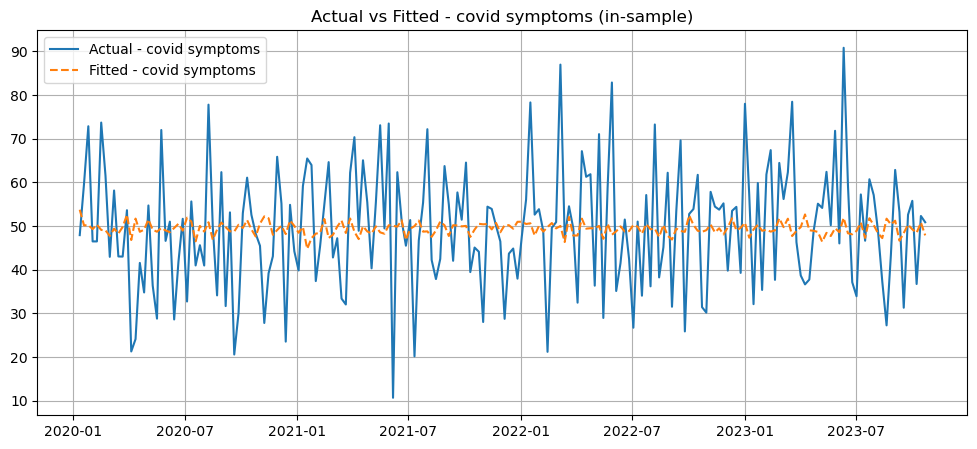

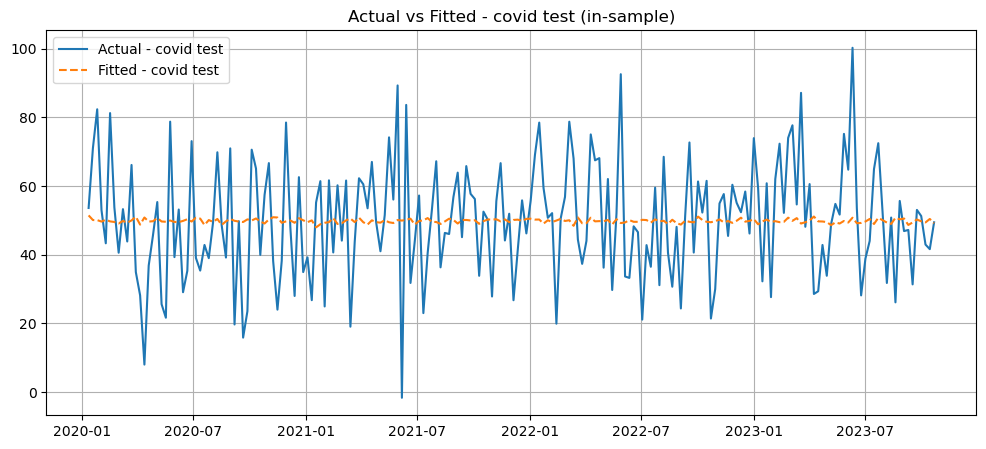

In [51]:
# Get fitted values from the VAR(1) model (on train data)
fitted_values = results.fittedvalues
fitted_values.index = train_data.index[1:] # because VAR drops first obs due to lag

# Align actual and fitted
actual = train_data[['covid symptoms', 'covid test']].iloc[1:] # match fitted

# Plot: covid symptoms
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(actual['covid symptoms'], label='Actual - covid symptoms')
plt.plot(fitted_values['covid symptoms'], label='Fitted - covid symptoms', linestyle='--')
plt.title("Actual vs Fitted - covid symptoms (in-sample)")
plt.legend()
plt.grid(True)
plt.show()

# Plot: covid test
plt.figure(figsize=(12, 5))
plt.plot(actual['covid test'], label='Actual - covid test')
plt.plot(fitted_values['covid test'], label='Fitted - covid test', linestyle='--')
plt.title("Actual vs Fitted - covid test (in-sample)")
plt.legend()
plt.grid(True)
plt.show()

Diagnostic: Actual vs Fitted Values (In-Sample)

To evaluate the in-sample fit of the VAR(1) model, we plotted the actual and fitted values for both time series: "covid symptoms" and "covid test".

**Observations:**

- For **covid symptoms**, the fitted values generally follow the trend of the actual values. However, the model appears to smooth out the fluctuations, failing to fully capture the high variability present in the actual data.

- For **covid test**, the fitted values remain almost flat and do not reflect the changes in the actual data at all. This suggests that the model is not able to capture meaningful dynamics in this series.

These observations are consistent with earlier results: low Granger causality and insignificant coefficients in the VAR(1) model indicate that the series may not be strongly connected dynamically.

In conclusion, while the model approximates the "covid symptoms" series to some extent, it performs poorly in capturing the behavior of the "covid test" series within the training period.

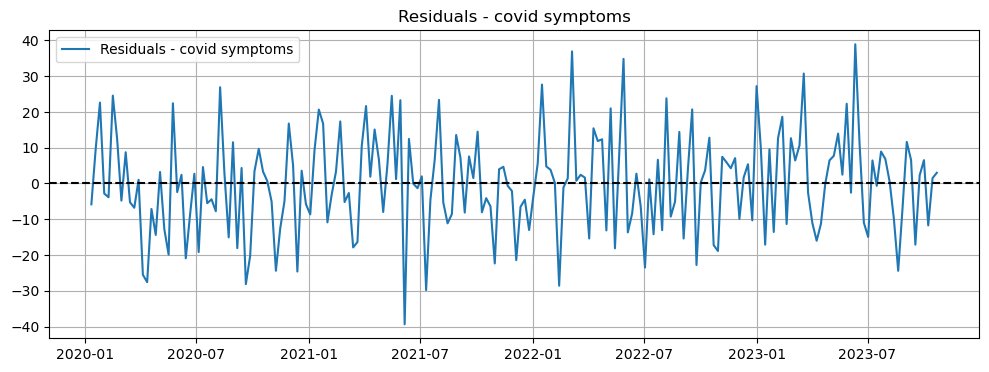

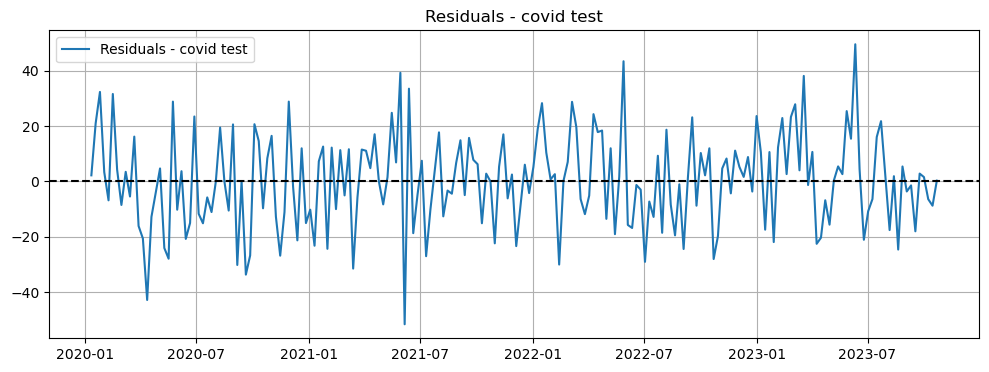

In [52]:
# Calculate residuals: Actual - Fitted
residuals = actual - fitted_values

# Plot residuals for covid symptoms
plt.figure(figsize=(12, 4))
plt.plot(residuals['covid symptoms'], label='Residuals - covid symptoms')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals - covid symptoms")
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals for covid test
plt.figure(figsize=(12, 4))
plt.plot(residuals['covid test'], label='Residuals - covid test')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals - covid test")
plt.legend()
plt.grid(True)
plt.show()

Diagnostic: Residual Plots

We plotted the residuals (actual - fitted values) from the VAR(1) model for both time series.

**covid symptoms:**
- The residuals fluctuate within a ±40 range.
- Some patterns or clusters appear in certain periods, but overall the residuals are centered around zero.
- This suggests moderate fit, with some periods of under- or over-estimation.

**covid test:**
- The residuals are more stable, fluctuating mostly within ±25.
- However, the values appear quite noisy and random, which could indicate a weak explanatory structure captured by the VAR(1) model for this series.

These plots confirm the findings from the fitted value plots: while the model captures "covid symptoms" moderately well, it struggles to explain "covid test".

<Figure size 1200x400 with 0 Axes>

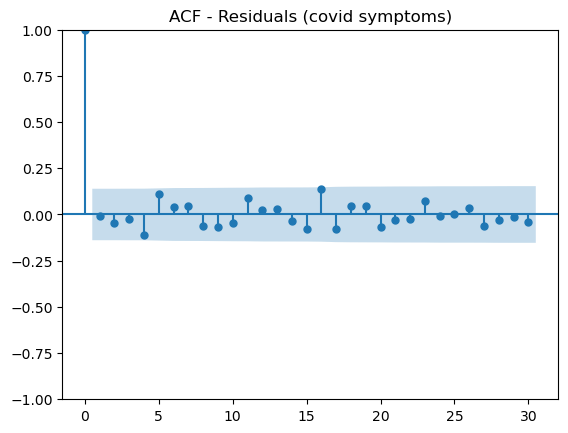

<Figure size 1200x400 with 0 Axes>

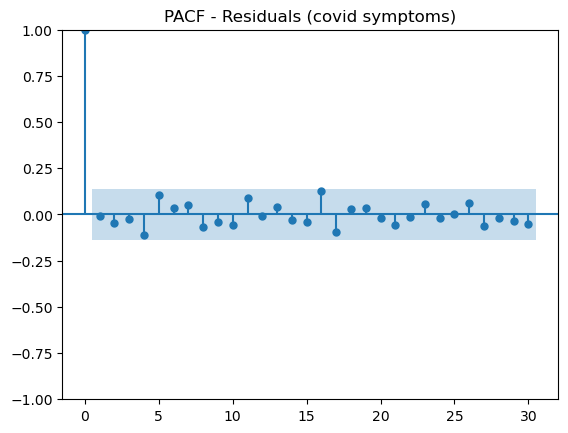

<Figure size 1200x400 with 0 Axes>

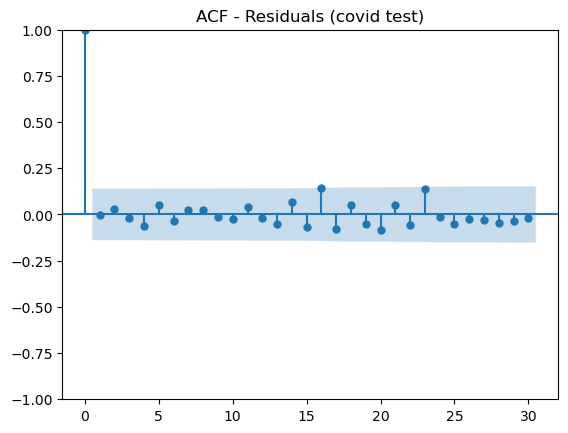

<Figure size 1200x400 with 0 Axes>

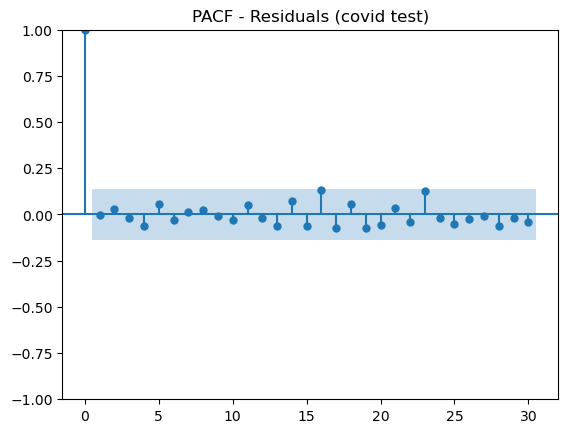

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF/PACF for covid symptoms residuals
plt.figure(figsize=(12, 4))
plot_acf(residuals['covid symptoms'], lags=30, title='ACF - Residuals (covid symptoms)')
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(residuals['covid symptoms'], lags=30, title='PACF - Residuals (covid symptoms)', method='ywm')
plt.show()

# ACF/PACF for covid test residuals
plt.figure(figsize=(12, 4))
plot_acf(residuals['covid test'], lags=30, title='ACF - Residuals (covid test)')
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(residuals['covid test'], lags=30, title='PACF - Residuals (covid test)', method='ywm')
plt.show()

Diagnostic: ACF and PACF of Residuals

To assess whether the VAR(1) model has adequately captured the autocorrelation structure of the data, we examined the ACF and PACF plots of the residuals for both time series.

**covid symptoms:**
- Both ACF and PACF plots show that the autocorrelations lie well within the 95% confidence bounds.
- No significant lags stand out, which suggests that the residuals are approximately white noise.
- This indicates that the model effectively captures the dynamic structure of this series.

**covid test:**
- Similarly, the ACF and PACF plots for "covid test" residuals do not show any significant autocorrelation.
- The residuals are scattered randomly around zero, with no visible pattern or significant spikes.
- Despite the poor model fit in terms of actual vs fitted values, the lack of autocorrelation suggests that the residuals are not predictable, and the model is not missing clear lag structure.

**Conclusion:**
For both series, the residuals appear to be uncorrelated, which validates the use of VAR(1) from a diagnostic standpoint. However, the overall model performance still varies across series — it is more effective for "covid symptoms" than for "covid test".

In [54]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test residuals from both series separately
ljung_symptoms = acorr_ljungbox(residuals['covid symptoms'], lags=[10], return_df=True)
ljung_test = acorr_ljungbox(residuals['covid test'], lags=[10], return_df=True)

print("Portmanteau (Ljung-Box) Test for residuals:")
print("-------------------------------------------------")
print("covid symptoms:")
print(ljung_symptoms)

print("\ncovid test:")
print(ljung_test)

Portmanteau (Ljung-Box) Test for residuals:
-------------------------------------------------
covid symptoms:
     lb_stat  lb_pvalue
10  8.689812   0.561773

covid test:
     lb_stat  lb_pvalue
10  2.345096   0.992946


Diagnostic: Portmanteau (Ljung-Box) Test for Residuals

To formally test for the presence of autocorrelation in the residuals, we applied the Portmanteau (Ljung-Box) test at lag 10 for both series.

**Results:**

- `covid symptoms`: p-value = 0.5618
- `covid test`: p-value = 0.9929

In both cases, the p-values are significantly greater than 0.05.
This implies that we fail to reject the null hypothesis of **no autocorrelation** in the residuals.

**Conclusion:**

These results confirm our earlier visual interpretation of the ACF and PACF plots.
The residuals appear to behave like white noise, indicating that the VAR(1) model has adequately captured the autocorrelation structure in both time series.

In [55]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

# Test for covid symptoms residuals
X_sym = sm.add_constant(data['covid test']) # covid test is independent
model_sym = sm.OLS(data['covid symptoms'], X_sym).fit()
bg_symptoms = acorr_breusch_godfrey(model_sym, nlags=10)

# Test for covid test residuals
X_test = sm.add_constant(data['covid symptoms']) # covid symptoms is independent
model_test = sm.OLS(data['covid test'], X_test).fit()
bg_test = acorr_breusch_godfrey(model_test, nlags=10)

print("Breusch-Godfrey LM Test (covid symptoms):")
print(f"LM stat: {bg_symptoms[0]:.4f}, p-value: {bg_symptoms[1]:.4f}")

print("\nBreusch-Godfrey LM Test (covid test):")
print(f"LM stat: {bg_test[0]:.4f}, p-value: {bg_test[1]:.4f}")

Breusch-Godfrey LM Test (covid symptoms):
LM stat: 14.0491, p-value: 0.1708

Breusch-Godfrey LM Test (covid test):
LM stat: 4.3100, p-value: 0.9323


Diagnostic: Breusch-Godfrey LM Test for Residuals

As a complement to the Portmanteau test, we performed the Breusch-Godfrey LM test to check for autocorrelation in the residuals individually for each time series.

**Results (lag = 10):**

- `covid symptoms`:
LM statistic = 14.0491, p-value = 0.1708

- `covid test`:
LM statistic = 4.3100, p-value = 0.9323

Since both p-values are greater than 0.05, we fail to reject the null hypothesis of no autocorrelation.

**Conclusion:**

The Breusch-Godfrey test confirms that the residuals from both series are free of significant autocorrelation. This supports the diagnostic results obtained from the ACF/PACF plots and the Portmanteau test, reinforcing the validity of the chosen VAR(1) model.